In [1]:
import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
from omegaconf import OmegaConf
import torch
from dabs.src.systems import viewmaker_original
from tqdm import tqdm
import os 
from torchvision.utils import save_image
import torch.nn.functional as F
import numpy as np
import torchattacks as ta
from torchvision import models, transforms
import pandas as pd
from torch import nn

In [2]:
dataset = 'mnist'

if dataset == 'traffic':
    conf_yaml = '/workspace/dabs/conf/traffic.yaml'
    conf_dataset_yaml = '/workspace/dabs/conf/dataset/traffic_sign_small.yaml'
    conf_model_yaml = '/workspace/dabs/conf/model/traffic_model.yaml'
    ckpt = '/workspace/dabs/exp/models/traffic_budget_budget=0.005/model.ckpt'
    systemClass = viewmaker_original.TrafficViewMaker
    batch_size = 32
    

elif dataset == 'lfw':
    conf_yaml = '/workspace/dabs/conf/ceva.yaml'
    conf_dataset_yaml = '/workspace/dabs/conf/dataset/lfw_112.yaml'
    conf_model_yaml = '/workspace/dabs/conf/model/ceva_model.yaml'
    ckpt = '/workspace/dabs/exp/models/traffic_budget_budget=0.005/model.ckpt'
    systemClass = viewmaker_original.CevaViewmakerSystem
    batch_size = 32
    
    root = '/workspace/dabs/data/adv_data/lfw/date/experiment_name/'+part

    label_counters ={}

    def save_func(original,views_similarities,label, class_names):
        path = os.path.join(root, class_names[label])
        if not os.path.exists(path):
            os.makedirs(path)

        if label in label_counters:
            label_counters[label] += 1
        else:
            label_counters[label] = 0

        save_image(original,f'{path}/{label_counters[label]:04d}_original.jpg')

        for j in range(len(views_similarities)):
            unnormalized_view, similarity = views_similarities[j]
            save_image(unnormalized_view,f'{path}/{label_counters[label]:04d}_view_{j+1}_sim_{similarity:.3f}.jpg')

elif dataset == 'birds':
    conf_yaml = '/workspace/dabs/conf/birds.yaml'
    conf_dataset_yaml = '/workspace/dabs/conf/dataset/cu_birds_small.yaml'
    conf_model_yaml = '/workspace/dabs/conf/model/birds_model.yaml'
    ckpt = '/workspace/dabs/exp/models/birds_dyn_sweep_budget=0.025/model.ckpt'
    systemClass = viewmaker_original.BirdsViewMaker
    batch_size = 12
    
elif dataset == 'mnist':
    conf_yaml = '/workspace/dabs/conf/mnist.yaml'
    conf_dataset_yaml = '/workspace/dabs/conf/dataset/mnist.yaml'
    conf_model_yaml = '/workspace/dabs/conf/model/mnist_model.yaml'
    ckpt = '/workspace/dabs/exp/models/mnist_sweep_2023-01-21_06:32:36/model.ckpt'
    systemClass = viewmaker_original.MNISTViewMaker
    batch_size = 256
    


In [3]:
print('loading config...')
config = OmegaConf.load(conf_yaml)
config.dataset = OmegaConf.load(conf_dataset_yaml)
config.model = OmegaConf.load(conf_model_yaml)
config.dataset.batch_size = batch_size
config.debug = True
pl.seed_everything(config.trainer.seed)

print('loading VM...')
system = torch.load(ckpt)
system.cuda()
system.eval()




Global seed set to 0


loading config...
loading VM...


MNISTViewMaker(
  (model): MnistModel(
    (embed_modules): ModuleList()
    (mnist_model): MnistNet(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (dropout1): Dropout(p=0.25, inplace=False)
      (dropout2): Dropout(p=0.5, inplace=False)
      (fc1): Linear(in_features=9216, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (viewmaker): Viewmaker(
    (act): ReLU()
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
      (conv2d): Conv2d(2, 32, kernel_size=(9, 9), stride=(1, 1))
    )
    (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (conv2): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    )
    (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Fals

In [4]:
from types import MethodType
if dataset == 'traffic':
    def forward_original(self, x):
        # transform the input
        x = self.stn(x)

        # Perform forward pass
        x = self.bn1(F.max_pool2d(F.leaky_relu(self.conv1(x)),2))
        x = self.conv_drop(x)
        x = self.bn2(F.max_pool2d(F.leaky_relu(self.conv2(x)),2))
        x = self.conv_drop(x)
        x = self.bn3(F.max_pool2d(F.leaky_relu(self.conv3(x)),2))
        x = self.conv_drop(x)
        x = x.view(-1, 250*2*2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    system.model.traffic_model.forward = MethodType(forward_original, system.model.traffic_model)
    threat_model  = system.model.traffic_model
    MEAN,STD = np.array([0.3337, 0.3064, 0.3171],dtype=np.float32), np.array([ 0.2672, 0.2564, 0.2629],dtype=np.float32)
    defense_path = '/workspace/gtsrb_pytorch/model_defended.pth' # FGSM e=0.005

elif dataset == 'birds':
    def new_forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        return F.softmax(x, dim = -1)

    system.model.birds_model.forward = MethodType(new_forward, system.model.birds_model)
    threat_model  = system.model.birds_model
    MEAN = [0.483, 0.491, 0.424]
    STD  = [0.228, 0.224, 0.259]
    defense_path = '/workspace/cubirds/resnet18-adv.pt' # FGSM e=0.025

       

elif dataset == 'mnist':
    def new_forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        y = self.dropout2(x)
        x = self.fc2(y)
        output = F.log_softmax(x, dim=1)
        return output

    system.model.mnist_model.forward = MethodType(new_forward, system.model.mnist_model)
    threat_model  = system.model.mnist_model

    # threat_model = models.resnet18(pretrained=False)
    # threat_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 
    # num_ftrs = threat_model.fc.in_features
    # threat_model.fc = nn.Linear(num_ftrs, 10)
    # threat_model.load_state_dict(torch.load('/workspace/MNIST/mnist_res18.pt'))
    # threat_model.eval().cuda()

    defense_path = '/workspace/MNIST/mnist_defense.pt' # FGSM e=0.3
    MEAN = [0.1307]
    STD  = [0.3081]
    

### advGAN inference

In [9]:
# load target_model
from adversarial_examples_pytorch.adv_gan import target_models
model_name = 'Model_C'
thres=0.3
f = getattr(target_models, model_name)(1, 10)
checkpoint_path_f = os.path.join('/workspace/adversarial_examples_pytorch/adv_gan/saved', 'target_models', 'best_%s_mnist.pth.tar'%(model_name))
checkpoint_f = torch.load(checkpoint_path_f, map_location='cpu')
f.load_state_dict(checkpoint_f["state_dict"])
f.eval()
f.cuda()
from adversarial_examples_pytorch.adv_gan.generators import Generator_MNIST as Generator
# load corresponding generator
G = Generator()
checkpoint_name_G = '%s_untargeted.pth.tar'%(model_name)
checkpoint_path_G = os.path.join('/workspace/adversarial_examples_pytorch/adv_gan/saved', 'generators', 'bound_%.1f'%(thres), checkpoint_name_G)
checkpoint_G = torch.load(checkpoint_path_G, map_location='cpu')
G.load_state_dict(checkpoint_G['state_dict'])
G.eval()
G.cuda()


Generator_MNIST(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (in1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (in2): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (in3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (resblock1): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (in2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (relu): ReLU(inplace=True)
  )
  (resblock2): ResidualBlock(
    (conv1): Conv2d(32, 32, ker

In [6]:
import copy
defense = 'no'
# defense = 'defended'
if defense == "defended":
    defended = copy.deepcopy(threat_model)
    defended.load_state_dict(torch.load(defense_path))
    defended.eval()
    test_model = defended
else:
    test_model = threat_model

In [7]:
run='vm'
# run='advgan'
pl.seed_everything(123654)


df_dict = {
    "label" : [],
    "pred" : [],
    "adv_pred": []
}
num_views = 3

loaders = [system.train_dataloader(), system.val_dataloader()]

if run=='vm':
    # VM
    for loader in loaders:
        for index , img , labels in tqdm(loader):
            with torch.no_grad():
                img = img.cuda()
                for i in range(num_views):
                    views1, _ = system.view(img, True)
                    pred = test_model(system.normalize(img)).argmax(1, keepdim = True)
                    adv_pred = test_model(views1).argmax(1, keepdim = True)

                    df_dict['label'].append(labels.unsqueeze(-1).cpu())
                    df_dict['pred'].append(pred.cpu())
                    df_dict['adv_pred'].append(adv_pred.cpu())
if run=='advgan':
    # VM
    for loader in loaders:
        for index , img , labels in tqdm(loader):
            with torch.no_grad():
                img = img.cuda()
                for i in range(num_views):
                    # load img and preprocess as required by f and G
                    x = img
                    pert = G(x).data.clamp(min=-thres, max=thres)
                    x_adv = x + pert #*0.3/pert.abs().mean() # L1 normalize (after L_inf ?)
                    x_adv = x_adv.clamp(min=0, max=1)
                    views1 = system.normalize(x_adv)

                    pred = test_model(system.normalize(img)).argmax(1, keepdim = True)
                    adv_pred = test_model(views1).argmax(1, keepdim = True)

                    df_dict['label'].append(labels.unsqueeze(-1).cpu())
                    df_dict['pred'].append(pred.cpu())
                    df_dict['adv_pred'].append(adv_pred.cpu())

elif run=='adv':
    # FGSM
    num_views = 1
    atk = ta.FGSM(threat_model, eps=0.005)
    # atk = ta.PGD(threat_model, eps=0.035, alpha=0.035/8, steps=10)
    
    atk.set_normalization_used(mean=MEAN, std=STD)
    for loader in loaders:
        for index , img , labels in tqdm(loader):
            # with torch.no_grad():
            img = img.cuda()
            for i in range(num_views):
                # views1, _ = system.view(img, True)
                views1 = atk(system.normalize(img),labels)
                pred = test_model(system.normalize(img)).argmax(1, keepdim = True)
                adv_pred = test_model(views1).argmax(1, keepdim = True)

                df_dict['label'].append(labels.unsqueeze(-1).cpu())
                df_dict['pred'].append(pred.cpu())
                df_dict['adv_pred'].append(adv_pred.cpu())


df_dict['label'] = torch.vstack(df_dict['label']).squeeze().numpy()
df_dict['pred'] = torch.vstack(df_dict['pred']).squeeze().numpy()
df_dict['adv_pred'] = torch.vstack(df_dict['adv_pred']).squeeze().numpy()

df = pd.DataFrame.from_dict(df_dict)


Global seed set to 123654
100%|██████████| 39/39 [00:01<00:00, 26.82it/s]


In [8]:
acc = (df['pred'] == df['adv_pred']).mean()
# adv_acc_0_001 = (df['pred'] == df['adv_pred']).mean()
# adv_acc_0_005 = (df['pred'] == df['adv_pred']).mean()
# adv_acc_0_035 = (df['pred'] == df['adv_pred']).mean()

In [7]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(df['pred'], df['adv_pred'], normalize='true')

In [57]:
# cf_matrix_0_035 = cf_matrix
# cf_matrix_0_005 = cf_matrix
cf_matrix_0_001 = cf_matrix

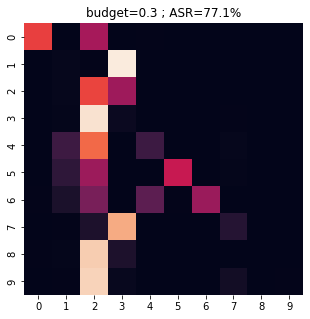

In [8]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
# sns.heatmap(cf_matrix, annot=True, fmt='.2f')
sns.heatmap(cf_matrix,cbar=False)#, annot=True, fmt='.2f')
plt.title(f'budget=0.3 ; ASR={(1-acc)*100:.1f}%')
plt.show()

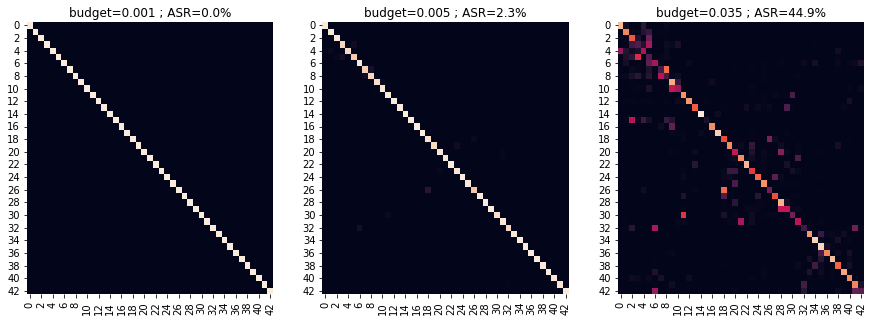

In [30]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
# sns.heatmap(cf_matrix, annot=True, fmt='.2f')
sns.heatmap(cf_matrix_0_001,cbar=False,ax=ax[0])#, annot=True, fmt='.2f')
ax[0].set_title(f'budget=0.001 ; ASR={(1-adv_acc_0_001)*100:.1f}%')
sns.heatmap(cf_matrix_0_005,cbar=False,ax=ax[1])#, annot=True, fmt='.2f')
ax[1].set_title(f'budget=0.005 ; ASR={(1-adv_acc_0_005)*100:.1f}%')
sns.heatmap(cf_matrix_0_035,cbar=False,ax=ax[2])#, annot=True, fmt='.2f')
ax[2].set_title(f'budget=0.035 ; ASR={(1-adv_acc_0_035)*100:.1f}%')
plt.show()

In [38]:

# if dataset == 'mnist80%':
mnist80_conf_yaml = '/workspace/dabs/conf/mnist.yaml'
mnist80_conf_dataset_yaml = '/workspace/dabs/conf/dataset/mnist.yaml'
mnist80_conf_model_yaml = '/workspace/dabs/conf/model/mnist_model.yaml'
mnist80_ckpt = '/workspace/dabs/exp/models/mnist_80%_2023-01-22_12:05:47/model.ckpt'
mnist80_systemClass = viewmaker_original.MNISTViewMaker
mnist80_batch_size = 256
print('loading config...')
mnist80_config = OmegaConf.load(mnist80_conf_yaml)
mnist80_config.dataset = OmegaConf.load(mnist80_conf_dataset_yaml)
mnist80_config.model = OmegaConf.load(mnist80_conf_model_yaml)
mnist80_config.dataset.batch_size = mnist80_batch_size
mnist80_config.debug = True
pl.seed_everything(mnist80_config.trainer.seed)

print('loading VM...')
mnist80_system = torch.load(mnist80_ckpt)
mnist80_system.cuda()
mnist80_system.eval()

from MNIST.example import Model_C
mnist80_test_model = Model_C(1,10)
mnist80_test_model.load_state_dict(torch.load('/workspace/MNIST/model_c_not_normalized.pt'))
mnist80_test_model.eval().cuda()

run='vm'
pl.seed_everything(123654)


df_dict = {
    "label" : [],
    "pred" : [],
    "adv_pred": []
}
num_views = 3

loaders = [system.train_dataloader(), system.val_dataloader()]

if run=='vm':
    # VM
    for loader in loaders:
        for index , img , labels in tqdm(loader):
            with torch.no_grad():
                img = img.cuda()
                for i in range(num_views):
                    views1, _ = mnist80_system.view(img, True)
                    pred = mnist80_test_model(system.normalize(img)).argmax(1, keepdim = True)
                    adv_pred = mnist80_test_model(views1).argmax(1, keepdim = True)

                    df_dict['label'].append(labels.unsqueeze(-1).cpu())
                    df_dict['pred'].append(pred.cpu())
                    df_dict['adv_pred'].append(adv_pred.cpu())
                if (labels==0).sum()>0:
                    break



df_dict['label'] = torch.vstack(df_dict['label']).squeeze().numpy()
df_dict['pred'] = torch.vstack(df_dict['pred']).squeeze().numpy()
df_dict['adv_pred'] = torch.vstack(df_dict['adv_pred']).squeeze().numpy()

df = pd.DataFrame.from_dict(df_dict)


Global seed set to 0


loading config...
loading VM...


Global seed set to 123654
 31%|███       | 12/39 [00:00<00:01, 15.67it/s]


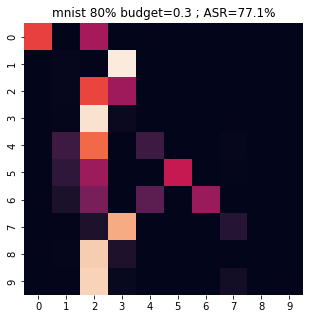

In [9]:
acc = (df['pred'] == df['adv_pred']).mean()
cf_matrix = confusion_matrix(df['pred'], df['adv_pred'], normalize='true')
plt.figure(figsize=(5,5))
sns.heatmap(cf_matrix,cbar=False)#, annot=True, fmt='.2f')
plt.title(f'mnist 80% budget=0.3 ; ASR={(1-acc)*100:.1f}%')
plt.show()

In [45]:
(views1[i]-img[i]).abs().mean()

tensor(0.0622, device='cuda:0')

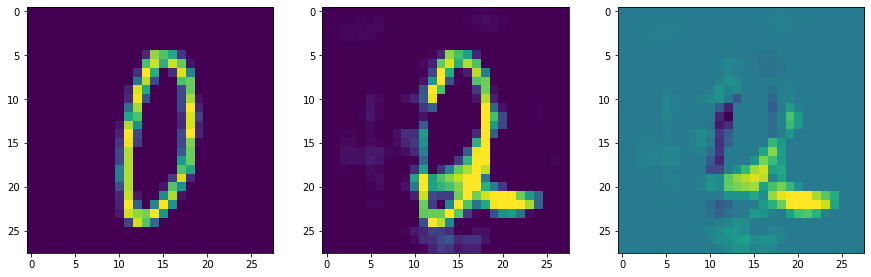

In [44]:
i=160
fig,ax = plt.subplots(1,3,figsize=(15,5))
# sns.heatmap(cf_matrix, annot=True, fmt='.2f')
ax[0].imshow(img[i].cpu().detach().squeeze())
ax[1].imshow(views1[i].cpu().detach().squeeze())
ax[2].imshow((views1[i]-img[i]).cpu().detach().squeeze())
plt.show()

In [10]:
acc_0 = (df[df['label']==0]['pred'] == df[df['label']==0]['adv_pred']).mean()
acc_5 = (df[df['label']==5]['pred'] == df[df['label']==5]['adv_pred']).mean()
acc_other = (df[(df['label']!=5) | (df['label']!=0)]['pred'] == df[(df['label']!=5) | (df['label']!=0)]['adv_pred']).mean()

In [11]:
1-acc_0,1-acc_5,1-acc_other

(0.4131884057971015, 0.5213824494548533, 0.7711385836385837)

In [12]:
((1-acc_0)+(1-acc_5))*0.5

0.4672854276259774

In [23]:
mnist80_test_model

Model_C(
  (conv1_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [1]:
import numpy as np

def misclassification_entropy(confusion_matrix):
    normalize_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1, keepdims=True)
    log_matrix = np.log2(normalize_matrix)
    entropy = -np.sum(normalize_matrix * log_matrix, axis=1)
    return entropy

# example confusion matrix
confusion_matrix = np.array([[30, 5], [10, 15]])

entropy = misclassification_entropy(confusion_matrix)
print("Misclassification entropy: ", entropy)


Misclassification entropy:  [0.59167278 0.97095059]
